In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import xlrd
import datetime

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [27]:
installs_path = '~/Downloads/lyft_installs.csv'
events_path = '~/Downloads/lyft_events.csv'

In [5]:
query_install = """
select
    ctp.tracking_time as preload_timestamp
    , cti.tracking_time as install_timestamp
    , ctp.advertising_id
    , ctp.referrer
    , extract(dow from ctp.tracking_time) as preload_day_of_week
    , extract(hour from ctp.tracking_time) as preload_hour_of_day 
    , extract(dow from cti.tracking_time) as install_day_of_week
    , extract(hour from cti.tracking_time) as install_hour_of_day
from rawdata.campaign_tracking_active_preload ctp 
left join rawdata.campaign_tracking_active_install cti 
    on ctp.reqid = cti.reqid
    and ctp.site_id = cti.site_id
    and cti.android_package_name = 'me.lyft.android'
    and date(cti.tracking_time) >= '02-04-2021'
where
    date(ctp.tracking_time) >= '02-04-2021'
    and ctp.android_package_name = 'me.lyft.android'
group by 1,2,3,4,5,6,7, 8
"""

In [6]:
query_firstrides = """
select
    pc_advertising_id as advertising_id
    , referrer
    , pc_install_timestamp
    , event_date
from rawdata.pi_data pi
where
    app_id = 'me.lyft.android'
    and event_date >= date('02-04-2021')
    and event = 'purchase'
    and referrer != 'empty'
group by 1,2,3,4
"""

In [7]:
cur_atlas.execute(query_install)
df_install = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [8]:
cur_atlas.execute(query_firstrides)
df_firstrides = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [9]:
df = pd.merge(df_install, df_firstrides, how = 'left', left_on = ['advertising_id', 'referrer'], right_on = ['advertising_id', 'referrer'])
df.count()


preload_timestamp       138747
install_timestamp        10755
advertising_id          138670
referrer                138747
preload_day_of_week     138747
preload_hour_of_day     138747
install_day_of_week      10755
install_hour_of_day      10755
pc_install_timestamp       213
event_date                 213
dtype: int64

In [60]:
df_events = pd.read_csv(events_path)
df_events['referrer'] = df_events['referrer'].replace('empty',np.nan)
df_installs = pd.read_csv(installs_path)
df_installs['timestamp'] = pd.to_datetime(df_installs['timestamp'], unit='ms')
event_start_dt = min(df_events.loc[df_events['referrer'].str.contains('APPIA', na=False),'date'])
event_end_dt = max(df_events.loc[df_events['referrer'].str.contains('APPIA', na=False),'date'])
df_organic = pd.merge(df_installs,df_events, left_on = ['aaid'], right_on = ['aaid'], suffixes = ['_install', '_event'], how = 'left')
df_organic = df_organic[['referrer_install','aaid','appIdentifier','timestamp','referrer_event','date']]
df_organic.columns = ['organic_install_referrer','aaid','package_name','organic_install_timestamp','organic_event_referrer','organic_event_timestamp']
df_organic = df_organic[(df_organic['organic_event_timestamp'] >= df_organic['organic_install_timestamp']) | (df_organic['organic_event_timestamp'].isna())]
df_organic.sample(30)

organic_install_referrer                                  aaid  \
324037                      NaN  0eec4680-1d73-492a-9ed9-901ff97873a4   
58296                       NaN  9c5e9c1b-aa06-437f-9c42-b2807e250949   
686350                      NaN  25a36811-c592-4778-a874-0557aed2df9f   
534503                      NaN  11bfdb09-15b0-4c10-a68c-1d3e20de6472   
222115                      NaN  c488c7d6-5c2a-424b-9fff-16ee552b679b   
658021                      NaN  247ad4cf-eae4-4501-98d1-1a47b0afac61   
116976                      NaN  071f5aec-e514-4bac-ba51-15b9f0dab750   
161808                      NaN  26ffb7f7-99f6-4fc2-bec4-c8c9a4cfe55f   
315830                      NaN  7f880eb9-d1c5-45b5-af8f-8fd67dd7170d   
640235                      NaN  84a18238-c66d-4d15-be58-ccd921fb55e3   
284539                      NaN  e25c3b24-7f5d-400d-9f15-42af695822d0   
566096                      NaN  30121139-2961-432b-a822-fadf7f7fe681   
668871                      NaN  8fa9d597-6eb4-4163-a28e-97f5c7852d4f   
98042                       NaN  b107790d-8958-44cc-b27d-0c09f625e187   
238462                      NaN  cad38ac5-76b8-4c9d-8446-40d53661a280   
287675                      NaN  0f1c27bf-6b64-4592-ae6e-0b887abba3fd   
536503                      NaN  5514819e-ea81-4e76-86f1-f605eb426dde   
647467                      NaN  aa404691-f0c6-4785-9be2-ed1872627b97   
340413                      NaN  35173a5a-9a28-4eb9-948f-8336f696f267   
620514                      NaN  5142453b-2d2b-48d8-acc8-307cb595c1a9   
672680                      NaN  b65e92a1-c55d-4af2-b0b2-526054623a86   
576252                      NaN  b3301d40-e70d-411c-b6fb-c972a7418fb5   
258751                      NaN  5184a5bc-f096-41fd-9ac8-daad1b653cf2   
594013                      NaN  0acfdec0-fa1a-4776-897b-97824e9c2e60   
596097                      NaN  611ebbb1-6608-481c-a4d4-eab5bab8c898   
172747                      NaN  7e5679f5-41dc-457d-bd8b-8e600e589e3d   
477514                      NaN  28fe2710-70ba-4181-98e6-c13fe1c7048c   
363019                      NaN  f4d2abf1-00f3-45f8-892e-4cec3dd53ff0   
644472                      NaN  d9f8106b-8798-4267-98d1-e5cc33c607a5   
375276                      NaN  f21acd35-9f5b-43e3-ad64-a0ff236f5778   

           package_name organic_install_timestamp organic_event_referrer  \
324037  me.lyft.android   2021-02-17 12:39:44.491                    NaN   
58296   me.lyft.android   2021-02-19 08:39:00.719                    NaN   
686350  me.lyft.android   2021-02-12 19:41:01.656                    NaN   
534503  me.lyft.android   2021-02-14 23:49:00.987                    NaN   
222115  me.lyft.android   2021-02-13 18:19:02.980                    NaN   
658021  me.lyft.android   2021-02-07 08:23:02.080                    NaN   
116976  me.lyft.android   2021-02-19 08:25:03.107                    NaN   
161808  me.lyft.android   2021-02-04 17:59:01.571                    NaN   
315830  me.lyft.android   2021-02-13 18:51:03.192                    NaN   
640235  me.lyft.android   2021-02-08 23:46:01.523                    NaN   
284539  me.lyft.android   2021-02-14 03:56:01.955                    NaN   
566096  me.lyft.android   2021-02-15 21:10:01.921                    NaN   
668871  me.lyft.android   2021-02-04 22:39:01.127                    NaN   
98042   me.lyft.android   2021-02-13 23:59:01.928                    NaN   
238462  me.lyft.android   2021-02-19 18:12:00.960                    NaN   
287675  me.lyft.android   2021-02-16 05:27:01.269                    NaN   
536503  me.lyft.android   2021-02-10 19:07:03.302                    NaN   
647467  me.lyft.android   2021-02-09 19:45:01.067                    NaN   
340413  me.lyft.android   2021-02-08 15:44:48.241                    NaN   
620514  me.lyft.android   2021-02-21 05:50:03.093                    NaN   
672680  me.lyft.android   2021-02-13 21:23:00.988                    NaN   
576252  me.lyft.android   2021-02-16 17:46:02.751                    Na

In [11]:
df['event_date'] = df['event_date'].astype('datetime64')
df['event_day_of_week'] = (df['event_date'] + pd.to_timedelta(1, unit='d')).dt.weekday
df['event_hour_of_day'] = df['event_date'].dt.hour

df['preload_to_install_days'] = (df['install_timestamp'] - df['preload_timestamp']).dt.days
df['preload_to_install_hours'] = (df['install_timestamp'] - df['preload_timestamp']).dt.total_seconds()/3600
df['install_to_event_days'] = (df['event_date'] - df['install_timestamp']).dt.days
df['install_to_event_hours'] = (df['event_date'] - df['install_timestamp']).dt.total_seconds()/3600
df['preload_to_event_days'] = (df['event_date'] - df['preload_timestamp']).dt.days
df['preload_to_event_hours'] = (df['event_date'] - df['preload_timestamp']).dt.total_seconds()/3600
df[~df.event_date.isna()]

preload_timestamp   install_timestamp  \
27     2021-02-08 12:54:21 2021-02-11 21:57:02   
1125   2021-02-07 02:15:56 2021-02-10 00:54:01   
1554   2021-02-16 16:33:05 2021-02-19 14:47:02   
5979   2021-02-15 07:15:45 2021-02-15 07:42:01   
7590   2021-02-15 17:43:51 2021-02-15 20:35:01   
...                    ...                 ...   
133779 2021-02-16 11:13:16 2021-02-19 12:44:02   
135608 2021-02-07 17:32:34 2021-02-09 12:29:02   
137970 2021-02-04 21:11:25 2021-02-10 08:12:04   
138369 2021-02-18 12:24:26 2021-02-22 08:51:01   
138647 2021-02-16 00:02:35 2021-02-16 13:03:02   

                              advertising_id  \
27      2e891c91-0a02-4ac4-80da-a43eee38822e   
1125    172610d6-0baf-4884-aea1-37c9d044d815   
1554    58d32bb7-c97d-4bb2-82b3-49d3ae6f98a1   
5979    aa63267d-2cc2-495d-9ad2-5590b75aea9e   
7590    ccf7d302-b16f-407c-a581-57b4bf001ab7   
...                                      ...   
133779  18563999-bd21-45da-8adf-918536901cbe   
135608  8243900e-ec65-46ac-8dfd-b1050fff032f   
137970  bcd3a55e-f034-4f21-b23d-ffab543c5fa9   
138369  4afdc162-9377-414e-a15b-0db8e3929d59   
138647  d8da5dfb-737e-4854-be1b-714528878dad   

                                            referrer  preload_day_of_week  \
27       APPIA89627999547137770414857932357442807193                    1   
1125    APPIA179807927093967625427781812039732986565                    0   
1554    APPIA145864843638297489710996924787305437683                    2   
5979    APPIA223458204812727675904164495446973895615                    1   
7590     APPIA86868660922205408976329129309839629561                    1   
...                                              ...                  ...   
133779   APPIA43348262213666054356210733212944807607                    2   
135608  APPIA295734502795155830982280969928276546041                    0   
137970  APPIA236757992540080212612699237255341289959                    4   
138369  APPIA205978387608476861867779731632702071485                    4   
138647  APPIA145077248623186512774237462274210841055                    2   

        preload_hour_of_day  install_day_of_week  install_hour_of_day  \
27                       12                  4.0                 21.0   
1125                      2                  3.0                  0.0   
1554                     16                  5.0                 14.0   
5979                      7                  1.0                  7.0   
7590                     17                  1.0                 20.0   
...                     ...                  ...                  ...   
133779                   11                  5.0                 12.0   
135608                   17                  2.0                 12.0   
137970                   21                  3.0                  8.0   
138369                   12                  1.0                  8.0   
138647                    0                  2.0                 13.0   

          pc_install_timestamp          event_date  event_day_of_week  \
27     2021-02-11 21:57:02.052 2021-02-12 13:33:53                5.0   
1125   2021-02-10 00:54:01.633 2021-02-10 04:49:33                3.0   
1554   2021-02-19 14:47:02.107 2021-02-19 15:31:48                5.0   
5979   2021-02-15 07:42:01.850 2021-02-23 00:06:57                2.0   
7590   2021-02-15 20:35:01.760 2021-02-15 23:49:03                1.0   
...                        ...                 ...                ...   
133779 2021-02-19 12:44:02.113 2021-02-19 13:34:16                5.0   
135608 2021-02-09 12:29:02.443 2021-02-09 13:20:20                2.0   
137970 2021-02-10 08:12:04.479 2021-02-10 08:49:34                3.0   
138369 2021-02-22 08:51:01.795 2021-02-22 09:32:55                1.0   
138647 2021-02-16 13:03:02.085 2021-02-16 13:48:01                2.0   

        event_hour_of_day  preload_to_install_days  preload_to_install_hours  \
27                   13.0                      3.0                 81.04

In [12]:
pivot_preload_to_install = df.pivot_table(values = 'install_timestamp', index = 'preload_to_install_days', aggfunc = lambda x:len(x.dropna().unique()))
pivot_preload_to_install['sov'] = pivot_preload_to_install['install_timestamp']/pivot_preload_to_install['install_timestamp'].sum()
pivot_preload_to_install
                                                           

install_timestamp       sov
preload_to_install_days                             
0.0                                   4393  0.417983
1.0                                   1098  0.104472
2.0                                    748  0.071170
3.0                                   1304  0.124072
4.0                                    929  0.088392
5.0                                    449  0.042721
6.0                                    325  0.030923
7.0                                    240  0.022835
8.0                                    231  0.021979
9.0                                    181  0.017222
10.0                                   133  0.012655
11.0                                   123  0.011703
12.0                                   108  0.010276
13.0                                    76  0.007231
14.0                                    62  0.005899
15.0                                    47  0.004472
16.0                                    42  0.003996
17.0                                    18  0.001713
18.0                                     3  0.000285

<AxesSubplot:title={'center':'SOV of time-to-install by day'}, xlabel='preload_to_install_days'>

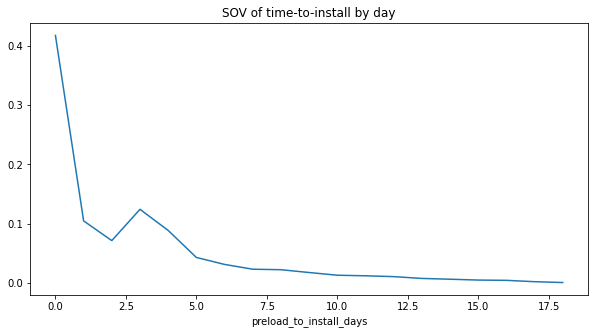

In [13]:
pivot_preload_to_install['sov'].plot(figsize = (10,5),title = 'SOV of time-to-install by day')

In [14]:
pivot_install_to_firstride = df.pivot_table(values = 'event_date', index = 'install_to_event_days', aggfunc = lambda x:len(x.dropna().unique()))
pivot_install_to_firstride['sov'] = pivot_install_to_firstride['event_date']/pivot_install_to_firstride['event_date'].sum()
pivot_install_to_firstride
                                                           

event_date       sov
install_to_event_days                      
0.0                           142  0.669811
1.0                            10  0.047170
2.0                            14  0.066038
3.0                            11  0.051887
4.0                             4  0.018868
5.0                             5  0.023585
6.0                             6  0.028302
7.0                             4  0.018868
8.0                             5  0.023585
9.0                             2  0.009434
10.0                            3  0.014151
11.0                            1  0.004717
12.0                            1  0.004717
13.0                            1  0.004717
14.0                            2  0.009434
15.0                            1  0.004717

<AxesSubplot:title={'center':'first ride sov by days since install'}, xlabel='install_to_event_days'>

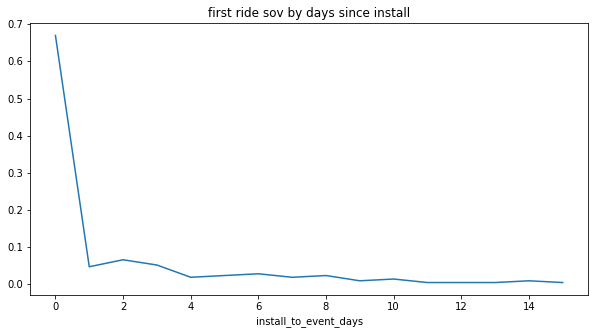

In [15]:
pivot_install_to_firstride['sov'].plot(figsize=(10,5),title = 'first ride sov by days since install')

Text(0.5, 0.98, 'Preloads, installs, and first rides cohorted to preload hour-of-day')

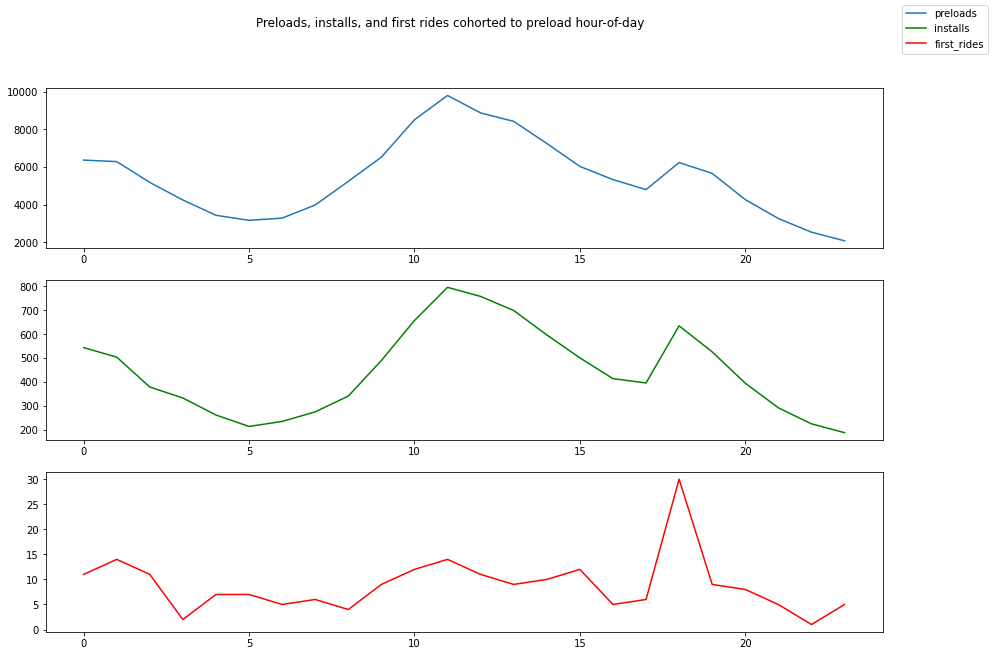

In [16]:
fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0].plot(df.pivot_table(values = ['preload_timestamp'], index = 'preload_hour_of_day',aggfunc = lambda x:len(x.dropna().unique())),label = 'preloads')
ax[1].plot(df.pivot_table(values = ['install_timestamp'], index = 'preload_hour_of_day',aggfunc = lambda x:len(x.dropna().unique())),label = 'installs',color = 'green')
ax[2].plot(df.pivot_table(values = ['event_date'], index = 'preload_hour_of_day',aggfunc = lambda x:len(x.dropna().unique())),label = 'first_rides',color = 'red')
fig.legend()
fig.suptitle('Preloads, installs, and first rides cohorted to preload hour-of-day')


Text(0.5, 0.98, 'Preloads, installs, and first rides cohorted to preload day_of_week (0 = Sunday)')

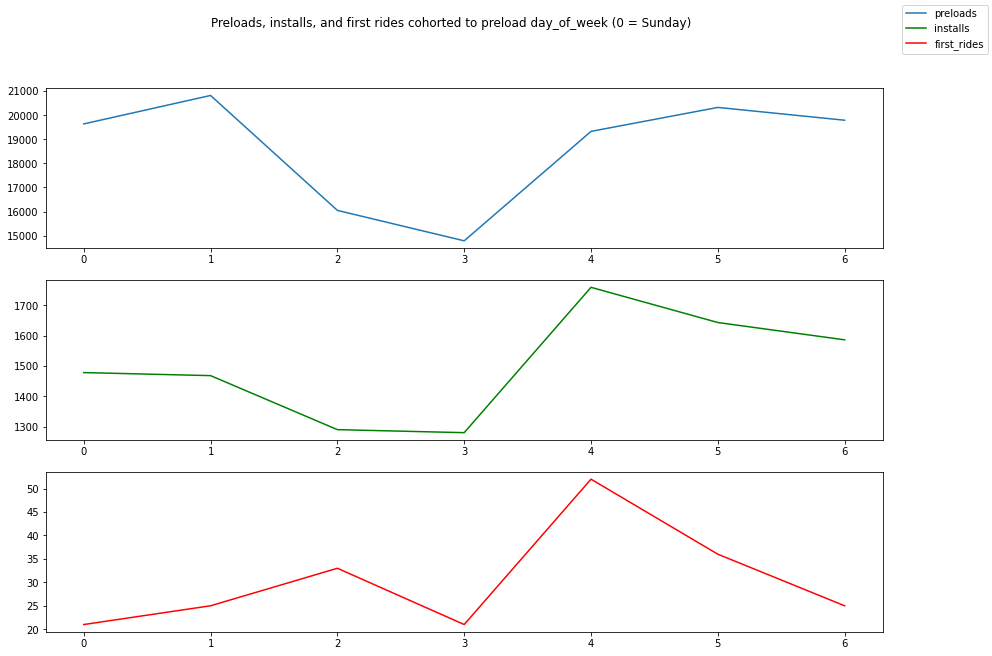

In [17]:
fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0].plot(df.pivot_table(values = ['preload_timestamp'], index = 'preload_day_of_week',aggfunc = lambda x:len(x.dropna().unique())),label = 'preloads')
ax[1].plot(df.pivot_table(values = ['install_timestamp'], index = 'preload_day_of_week',aggfunc = lambda x:len(x.dropna().unique())),label = 'installs',color = 'green')
ax[2].plot(df.pivot_table(values = ['event_date'], index = 'preload_day_of_week',aggfunc = lambda x:len(x.dropna().unique())),label = 'first_rides',color = 'red')
fig.legend()
fig.suptitle('Preloads, installs, and first rides cohorted to preload day_of_week (0 = Sunday)')


<AxesSubplot:title={'center':'first rides by day of week, uncohorted'}, xlabel='event_day_of_week'>

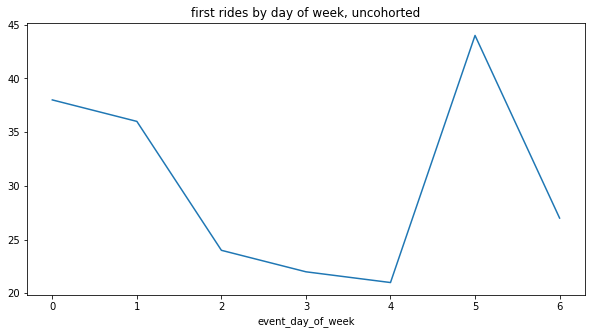

In [18]:
df.pivot_table(values = 'event_date', index = 'event_day_of_week',aggfunc = lambda x:len(x.dropna().unique())).plot(figsize = (10,5),title = 'first rides by day of week, uncohorted',legend=False)

In [19]:
df.pivot_table(values = ['event_date'], index = ['preload_day_of_week','event_day_of_week'],aggfunc = lambda x:len(x.dropna().unique())).sort_values('event_date',ascending=False)

event_date
preload_day_of_week event_day_of_week            
4                   5.0                        14
                    1.0                        10
5                   5.0                         9
                    0.0                         9
1                   1.0                         9
0                   0.0                         8
2                   5.0                         8
5                   1.0                         7
4                   6.0                         7
                    0.0                         6
2                   4.0                         6
                    3.0                         6
                    2.0                         6
4                   4.0                         6
6                   0.0                         6
3                   5.0                         6
                    6.0                         5
4                   3.0                         5
0                   1.0                         5
5                   6.0                         5
6                   6.0                         5
                    2.0                         4
2                   0.0                         4
6                   1.0                         4
4                   2.0                         4
1                   5.0                         4
                    2.0                         4
3                   4.0                         3
6                   5.0                         3
3                   0.0                         3
0                   2.0                         3
1                   3.0                         3
0                   3.0                         3
5                   3.0                         2
6                   4.0                         2
5                   4.0                         2
1                   0.0                         2
5                   2.0                         2
1                   6.0                         2
2                   6.0                         2
3                   3.0                         2
0                   6.0                         1
                    4.0                         1
3                   2.0                         1
1                   4.0                         1
2                   1.0                         1
6                   3.0                         1
3                   1.0                         1

In [70]:
df_w_organic = pd.merge(df,df_organic,left_on='advertising_id',right_on = 'aaid', how = 'left')
df_w_organic.dtypes
df_w_organic.loc[(~df_w_organic['organic_event_referrer'].str.contains('APPIA',na=False)) & (~df_w_organic.install_timestamp.isna()) & (~df_w_organic.organic_event_referrer.isna()),
                 ['preload_timestamp','install_timestamp','referrer','event_date','organic_install_referrer'
                  ,'organic_install_timestamp','organic_event_referrer','organic_event_timestamp']].tail(30)

Empty DataFrame
Columns: [preload_timestamp, install_timestamp, referrer, event_date, organic_install_referrer, organic_install_timestamp, organic_event_referrer, organic_event_timestamp]
Index: []

In [69]:
df_w_organic

preload_timestamp   install_timestamp  \
0      2021-02-04 19:10:10                 NaT   
1      2021-02-04 20:02:35                 NaT   
2      2021-02-04 20:30:09                 NaT   
3      2021-02-04 20:10:46                 NaT   
4      2021-02-04 20:36:12 2021-02-05 03:27:01   
...                    ...                 ...   
138953 2021-02-22 16:14:33                 NaT   
138954 2021-02-22 17:00:56                 NaT   
138955 2021-02-22 18:48:07                 NaT   
138956 2021-02-22 19:26:27                 NaT   
138957 2021-02-22 20:46:01                 NaT   

                              advertising_id  \
0       f4c3ede4-d615-441e-af65-78f720b0604a   
1       6b7ae528-c7a6-48e0-a0ba-ce15ed7a5c06   
2       2e033316-9f2f-40ba-aafb-8d801eab1164   
3       8d9137dd-8502-4ca7-8120-46fcd24552c2   
4       e112083e-508c-4755-b0ab-3d5244c42f40   
...                                      ...   
138953  5d398001-56a6-4aba-ad39-937f3555cd9e   
138954  498ffa6b-e264-4f69-85fb-701da1bbf031   
138955  32e9d4ed-080e-41b0-be36-ac2627248c5a   
138956  ba9b8ebf-cb96-4e21-a5c8-77b79cba5b99   
138957  d2a94d17-f671-4edf-beb1-f33808ce755b   

                                            referrer  preload_day_of_week  \
0       APPIA302616310238066871738423322402696518385                    4   
1       APPIA268354098033191456354752076925240050002                    4   
2        APPIA36265133612267138568820585585967162521                    4   
3       APPIA154435796819150752309560027410948495269                    4   
4       APPIA316306542474832416270434238188405047104                    4   
...                                              ...                  ...   
138953  APPIA205542410209857225733310104461611060542                    1   
138954   APPIA62238751462692828919087386204620144653                    1   
138955  APPIA106305678728001956131107896305832165216                    1   
138956  APPIA255904724340766565396563856674233026823                    1   
138957  APPIA269677612222271922827714405681803094634                    1   

        preload_hour_of_day  install_day_of_week  install_hour_of_day  \
0                        19                  NaN                  NaN   
1                        20                  NaN                  NaN   
2                        20                  NaN                  NaN   
3                        20                  NaN                  NaN   
4                        20                  5.0                  3.0   
...                     ...                  ...                  ...   
138953                   16                  NaN                  NaN   
138954                   17                  NaN                  NaN   
138955                   18                  NaN                  NaN   
138956                   19                  NaN                  NaN   
138957                   20                  NaN                  NaN   

       pc_install_timestamp event_date  ...  install_to_event_days  \
0                       NaT        NaT  ...                    NaN   
1                       NaT        NaT  ...                    NaN   
2                       NaT        NaT  ...                    NaN   
3                       NaT        NaT  ...                    NaN   
4                       NaT        NaT  ...                    NaN   
...                     ...        ...  ...                    ...   
138953                  NaT        NaT  ...                    NaN   
138954                  NaT        NaT  ...                    NaN   
138955                  NaT        NaT  ...                    NaN   
138956                  NaT        NaT  ...                    NaN   
138957                  NaT        NaT  ...                    NaN   

        install_to_event_hours  preload_to_event_days  preload_to_event_hours  \
0                          NaN                    NaN                     NaN   
1                         